### Aprendizaje Automático III Universidad ICESI
#### Andrés Felipe Palomino - Diego Fernando Agudelo - Daniel Felipe Osorio
#### palomino.andres@correounivalle.edu.co - dagudelo30@gmail.com -dfosorio@icesi.edu.co

### Clase 4 - Modelos para series de tiempo multiestacionales, puntos de cambio y festividades (Prophet)

In [3]:
import pandas as pd
import os

In [4]:
os.getcwd() 

'c:\\Users\\1130590314\\OneDrive - Universidad Icesi\\Cursos\\AAIII\\4. Clase Prophet\\src'

In [11]:
df = pd.read_parquet(r'C:\Users\1130590314\Downloads\df_final_ponderado_2015_2024.parquet')

In [15]:
df[['comuna', 'epi_week','epi_year','n_casos_semana_ponderado']]

,comuna,epi_week,epi_year,n_casos_semana_ponderado
0,01,2015-01,2015,0.171716
1,01,2015-02,2015,0.000000
2,01,2015-03,2015,0.221000
3,01,2015-04,2015,0.000000
4,01,2015-05,2015,0.000000
...,...,...,...,...
11955,81,2024-48,2024,4.777231
11956,81,2024-49,2024,5.937515
11957,81,2024-50,2024,6.695875
11958,81,2024-51,2024,6.772155


In [19]:
23*520

11960

In [18]:
df[['epi_week']].drop_duplicates()

,epi_week
0,2015-01
1,2015-02
2,2015-03
3,2015-04
4,2015-05
...,...
515,2024-48
516,2024-49
517,2024-50
518,2024-51


In [16]:
df.n_casos_comuna_ponderado.sum()

77157.34708923387

### Artículo original : https://facebook.github.io/prophet/static/prophet_paper_20170113.pdf

In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import optuna
import os

In [46]:
main_dir = os.path.dirname(os.getcwd())
inputs_dir = os.path.join(main_dir, "inputs")
outputs_dir = os.path.join(main_dir, "outputs")

# Ajuste de datos

In [8]:
page_vis = pd.read_csv(os.path.join(inputs_dir, 'page_visits_assignment.csv'))
page_vis['Date'] = page_vis['Date'].str.replace('-', '/')
page_vis['Date'] = pd.to_datetime(page_vis['Date'], errors='coerce', format='%m/%d/%Y')

### Validación de frecuencia de la Serie Temporal

In [9]:
page_vis['Date'].diff().dropna().value_counts()

Date
1 days    1826
Name: count, dtype: int64

### Sin datos faltantes

In [10]:
print(page_vis.isnull().sum())

Date            0
Visits          0
Easter          0
Christmas       0
Black Friday    0
dtype: int64


### Preparación de variables de interés

In [11]:
page_vis = page_vis.rename(columns={'Date': 'ds', 'Visits': 'y'})
page_vis = page_vis.set_index('ds', drop=False)

In [12]:
df_events = page_vis.melt(id_vars=['ds', 'y'], 
                          value_vars=['Easter', 'Christmas', 'Black Friday'],
                          var_name='Event', value_name='Value')

df_events = df_events[df_events['Value'] == 1]

In [13]:
df_events = df_events.set_index('ds', drop=False)

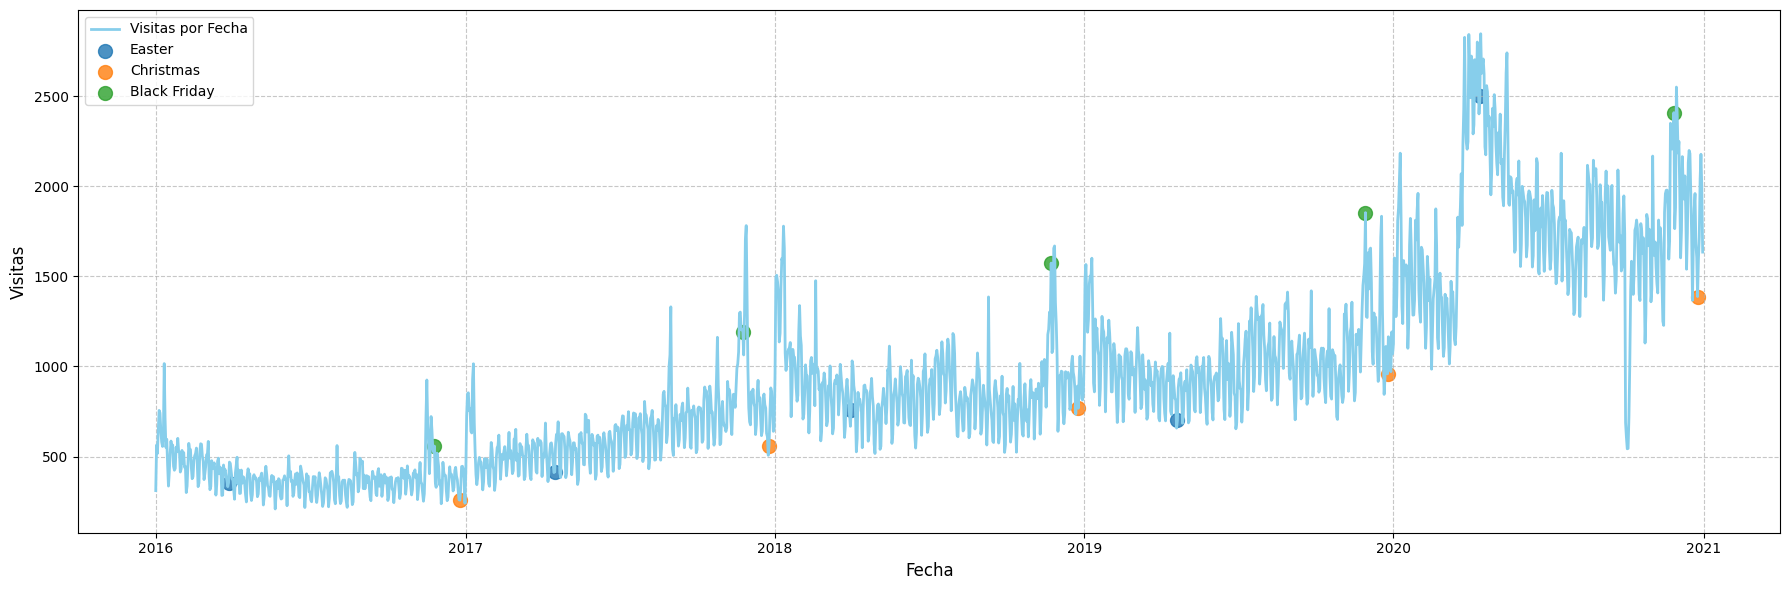

In [61]:
plt.figure(figsize=(18, 6)) 
plt.plot(page_vis['ds'], page_vis['y'], label='Visitas por Fecha', color='skyblue', linewidth=2)
for event_name in df_events['Event'].unique():
    df_plot = df_events[df_events['Event'] == event_name]
    plt.scatter(df_plot['ds'], df_plot['y'], marker='o', s=100, label=event_name, alpha=0.8)
plt.title('', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitas', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend() 
plt.tight_layout() 
plt.savefig(os.path.join(outputs_dir, 'img',"visitas_por_fecha.png"), dpi=300, bbox_inches='tight')
plt.show()

In [53]:
fig = px.line(page_vis, x='ds', y='y', title='Visitas por Fecha')
for event in df_events['Event'].unique():
    df_plot = df_events[df_events['Event'] == event]
    fig.add_trace(go.Scatter(
        x=df_plot['ds'], y=df_plot['y'], mode='markers', name=event
    ))
fig.update_layout(xaxis_title='Fecha', yaxis_title='Visitas', plot_bgcolor='white')
fig.show()
fig.write_html(os.path.join(outputs_dir,'html', "visitas_por_fecha.html"))

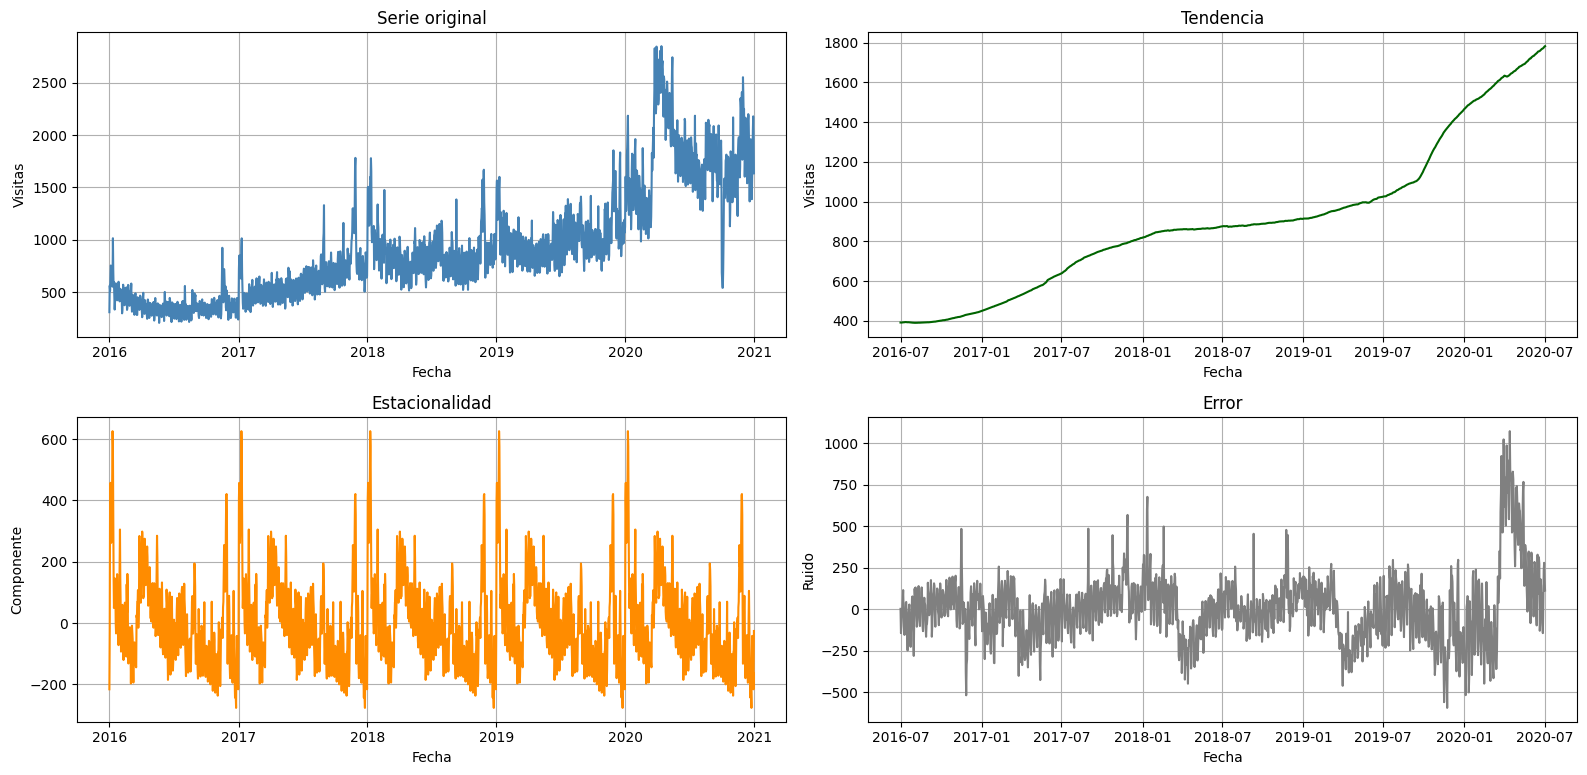

In [54]:
result = seasonal_decompose(page_vis['y'], model='additive', period=365)
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle("", fontsize=18, y=1.02)
axs[0, 0].plot(result.observed, color='steelblue')
axs[0, 0].set_title("Serie original")
axs[0, 0].set_ylabel("Visitas")
axs[0, 1].plot(result.trend, color='darkgreen')
axs[0, 1].set_title("Tendencia")
axs[0, 1].set_ylabel("Visitas")
axs[1, 0].plot(result.seasonal, color='darkorange')
axs[1, 0].set_title("Estacionalidad")
axs[1, 0].set_ylabel("Componente")
axs[1, 1].plot(result.resid, color='gray')
axs[1, 1].set_title("Error")
axs[1, 1].set_ylabel("Ruido")
for ax in axs.flat:
    ax.set_xlabel("Fecha")
    ax.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(outputs_dir,'img', "descomposicion_fecha.png"), dpi=300, bbox_inches='tight')
plt.show()

In [55]:
seasonal_df = result.seasonal.reset_index()
seasonal_df.columns = ['Fecha', 'Valor'] 
fig = px.line(seasonal_df, x='Fecha', y='Valor', title='Componente Estacional',
              labels={'Fecha': 'Fecha', 'Valor': 'Valor Estacional'},
              line_shape='linear')

fig.update_traces(line_color='darkorange')
fig.update_layout(template='plotly_white')
fig.show()
fig.write_html(os.path.join(outputs_dir,'html', "descomposicion.html"))

In [20]:
def create_holiday_df(name, df, lower, upper):
    dates = df[df[name] == 1]['ds']
    return pd.DataFrame({
        'holiday': name.replace(" ", "."),
        'ds': dates,
        'lower_window': lower,
        'upper_window': upper
    })
christmas = create_holiday_df('Christmas', page_vis, -3, 3)
black_friday = create_holiday_df('Black Friday', page_vis, -3, 1)
easter = create_holiday_df('Easter', page_vis, -3, 1)
holidays = pd.concat([christmas, black_friday, easter], ignore_index=True)

In [21]:
train = page_vis[page_vis['ds'] < '2020-12-01']
test = page_vis[page_vis['ds'] >= '2020-12-01']

In [22]:
m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(train[['ds', 'y']])

10:21:04 - cmdstanpy - INFO - Chain [1] start processing
10:21:05 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future = m.make_future_dataframe(periods=len(test), freq='D')
forecast = m.predict(future)
forecast_tail = forecast.tail(len(test)).copy()
test = test.copy()
test['yhat'] = forecast_tail['yhat'].values

In [24]:
impact_christmas = forecast[forecast['Christmas'].abs() > 0][['ds', 'Christmas']]
impact_black = forecast[forecast['Black.Friday'].abs() > 0][['ds', 'Black.Friday']]
impact_easter = forecast[forecast['Easter'].abs() > 0][['ds', 'Easter']]

In [25]:
impact_christmas

,ds,Christmas
356,2016-12-22,-104.240343
357,2016-12-23,-78.758839
358,2016-12-24,-174.400672
359,2016-12-25,-299.504400
360,2016-12-26,-221.701869
361,2016-12-27,-140.777602
362,2016-12-28,-146.457936
721,2017-12-22,-104.240343
722,2017-12-23,-78.758839
723,2017-12-24,-174.400672


In [27]:
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(m, forecast)
fig.update_layout(
    plot_bgcolor='white',   
    paper_bgcolor='white',  
    font=dict(color='black'),xaxis_title='Fecha', yaxis_title='Visitas'
)
fig.show()

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=test['ds'], y=test['y'],
    mode='lines',
    name='Observado',
    line=dict(color='black')
))
fig.add_trace(go.Scatter(
    x=test['ds'], y=test['yhat'],
    mode='lines',
    name='Pronosticado',
    line=dict(color='dodgerblue', dash='dash')
))
fig.update_layout(
    title='Comparación Observado vs Pronosticado (Test Set)',
    xaxis_title='Fecha',
    yaxis_title='Visitas',
    legend=dict(x=0.01, y=0.99),
    height=500,
    width=1000,
    template='simple_white'
)
fig.show()

In [29]:
fig_components = plot_components_plotly(m, forecast)
fig_components.update_layout(
    plot_bgcolor='white',  
    paper_bgcolor='white',
    font=dict(color='black')
)
fig_components.show()

In [30]:
rmse = np.sqrt(mean_squared_error(test['y'], test['yhat']))
mae = mean_absolute_error(test['y'], test['yhat'])
mape = np.mean(np.abs((test['y'] - test['yhat']) / test['y'])) * 100
accuracy = 100 - mape
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Precisión: {accuracy:.2f}%")

RMSE: 233.17
MAE: 183.28
MAPE: 10.65%
Precisión: 89.35%


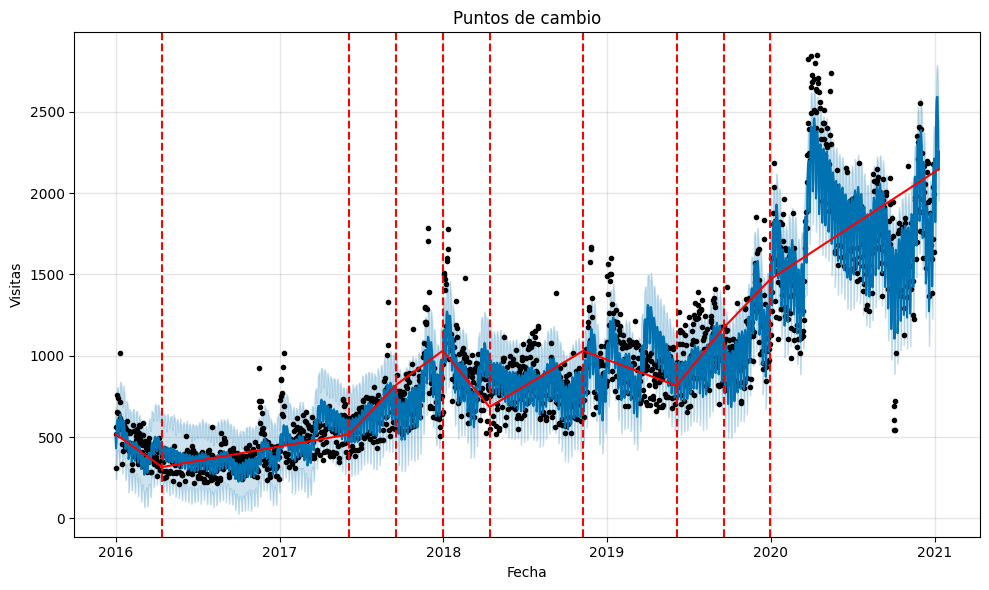

In [56]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title("Puntos de cambio")
plt.xlabel("Fecha")
plt.ylabel("Visitas")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(outputs_dir,'img', "puntos_de_cambio.png"), dpi=300, bbox_inches='tight')
plt.show()

In [32]:
deltas = np.abs(np.mean(m.params['delta'], axis=0))
threshold = np.percentile(deltas, 75)
significant_changepoints = m.changepoints[deltas >= threshold]
print("Puntos de cambio más significativos:")
print(significant_changepoints)

Puntos de cambio más significativos:
402    2017-02-06
459    2017-04-04
631    2017-09-23
689    2017-11-20
1205   2019-04-20
1263   2019-06-17
1435   2019-12-06
Name: ds, dtype: datetime64[ns]


#### Metodología de evaluación robusta 

In [33]:
def rolling_forecast_eval(data, params, holidays=None,
                          initial_train_size=365 * 2,
                          forecast_horizon=30,
                          step_size=30):
    
    data = data.sort_values('ds').reset_index(drop=True)
    n = len(data)
    metrics = []

    for start in range(0, n - initial_train_size - forecast_horizon + 1, step_size):
        train = data.iloc[start:start + initial_train_size]
        test = data.iloc[start + initial_train_size:start + initial_train_size + forecast_horizon]

        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            holidays=holidays,
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            n_changepoints=params['n_changepoints']
        )
        model.fit(train)

        forecast = model.predict(test[['ds']])

        y_true = test['y'].values
        y_pred = forecast['yhat'].values

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        metrics.append({
            'window_start': train['ds'].iloc[0],
            'window_end': train['ds'].iloc[-1],
            'rmse': rmse
        })

    return pd.DataFrame(metrics)

In [34]:
page_vis.index.name = None 
page_vis = page_vis[['ds', 'y', 'Easter', 'Christmas', 'Black Friday']]

In [35]:
def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float("changepoint_prior_scale", 0.001, 0.2, log=True),
        'seasonality_prior_scale': trial.suggest_float("seasonality_prior_scale", 0.01, 5, log=True),
        'holidays_prior_scale': trial.suggest_float("holidays_prior_scale", 0.01, 5, log=True),
        'seasonality_mode': trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]),
        'n_changepoints': trial.suggest_int("n_changepoints", 1, 20)
    }
    results_df = rolling_forecast_eval(page_vis, params, holidays=holidays)
    rmse_mean = results_df['rmse'].mean()
    trial.set_user_attr("rmse_by_window", results_df['rmse'].tolist())
    return rmse_mean

In [37]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2025-11-09 10:25:05,460] A new study created in memory with name: no-name-df2193f3-89b4-473b-8913-56215a9ec6a0
10:25:05 - cmdstanpy - INFO - Chain [1] start processing
10:25:06 - cmdstanpy - INFO - Chain [1] done processing
10:25:06 - cmdstanpy - INFO - Chain [1] start processing
10:25:06 - cmdstanpy - INFO - Chain [1] done processing
10:25:07 - cmdstanpy - INFO - Chain [1] start processing
10:25:07 - cmdstanpy - INFO - Chain [1] done processing
10:25:07 - cmdstanpy - INFO - Chain [1] start processing
10:25:07 - cmdstanpy - INFO - Chain [1] done processing
10:25:08 - cmdstanpy - INFO - Chain [1] start processing
10:25:08 - cmdstanpy - INFO - Chain [1] done processing
10:25:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:25:08 - cmdstanpy - INFO - Chain [1] start processing
10:25:09 - cmdstanpy - INFO - Chain [1] done processing
10:25:09 - cmdstanpy - INFO - Chain [1] start proces

10:29:18 - cmdstanpy - INFO - Chain [1] start processing
10:29:18 - cmdstanpy - INFO - Chain [1] done processing
10:29:19 - cmdstanpy - INFO - Chain [1] start processing
10:29:19 - cmdstanpy - INFO - Chain [1] done processing
10:29:19 - cmdstanpy - INFO - Chain [1] start processing
10:29:20 - cmdstanpy - INFO - Chain [1] done processing
10:29:20 - cmdstanpy - INFO - Chain [1] start processing
10:29:20 - cmdstanpy - INFO - Chain [1] done processing
10:29:21 - cmdstanpy - INFO - Chain [1] start processing
10:29:21 - cmdstanpy - INFO - Chain [1] done processing
10:29:21 - cmdstanpy - INFO - Chain [1] start processing
10:29:22 - cmdstanpy - INFO - Chain [1] done processing
10:29:22 - cmdstanpy - INFO - Chain [1] start processing
10:29:22 - cmdstanpy - INFO - Chain [1] done processing
10:29:23 - cmdstanpy - INFO - Chain [1] start processing
10:29:23 - cmdstanpy - INFO - Chain [1] done processing
10:29:23 - cmdstanpy - INFO - Chain [1] start processing
10:29:24 - cmdstanpy - INFO - Chain [1]

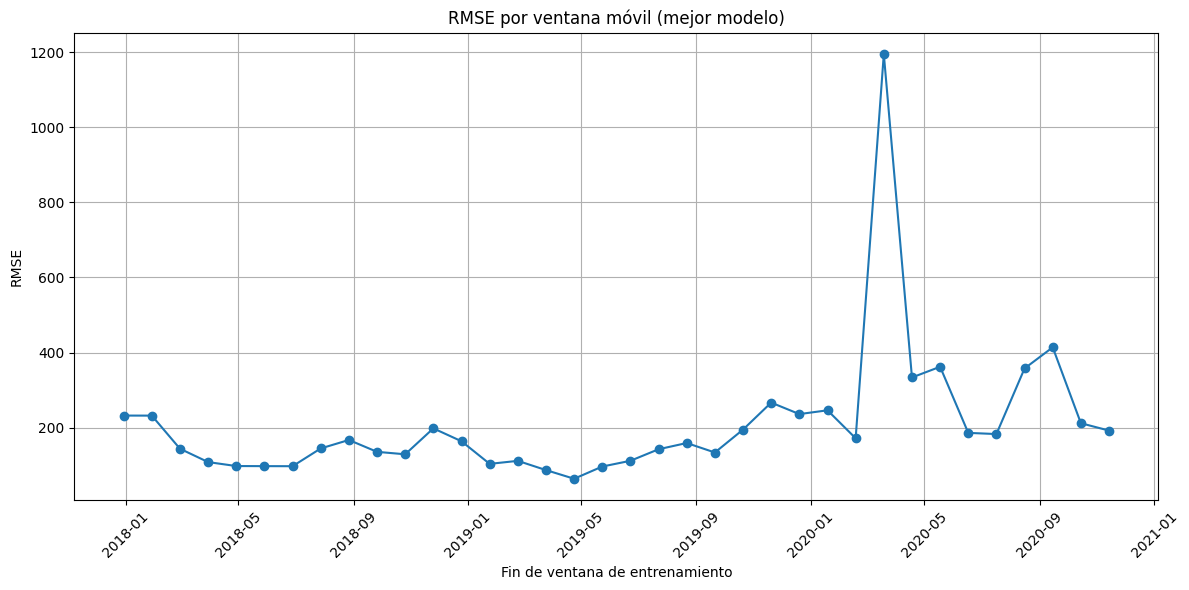

In [38]:
best_params = study.best_params
results_df = rolling_forecast_eval(page_vis, best_params, holidays=holidays)
plt.figure(figsize=(12, 6))
plt.plot(results_df['window_end'], results_df['rmse'], marker='o')
plt.title("RMSE por ventana móvil (mejor modelo)")
plt.xlabel("Fin de ventana de entrenamiento")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
print("Mejores hiperparámetros:")
print(study.best_params)
print("Promedio RMSE en ventanas:", results_df['rmse'].mean())

Mejores hiperparámetros:
{'changepoint_prior_scale': 0.08666016699089053, 'seasonality_prior_scale': 0.7136710182676306, 'holidays_prior_scale': 0.13019975994144592, 'seasonality_mode': 'multiplicative', 'n_changepoints': 14}
Promedio RMSE en ventanas: 208.41407195948784


In [41]:
import plotly.io as pio

In [57]:
pio.templates.default = "plotly_white"
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    n_changepoints=best_params['n_changepoints']
)
m.fit(page_vis[['ds', 'y']])
future = m.make_future_dataframe(periods=10)
future['Easter'] = 0
future['Christmas'] = 0
future['Black Friday'] = 0
forecast = m.predict(future)
forecast_future = forecast[forecast['ds'] > page_vis['ds'].max()][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fig = plot_plotly(m, forecast)
fig.update_layout(
    title="Pronóstico de visitas a 6 días",
    xaxis_title="Fecha",
    yaxis_title="Visitas",
    plot_bgcolor='white',      
    paper_bgcolor='white',    
    font=dict(color='black'), 
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)
fig.show()
fig.write_html(os.path.join(outputs_dir,'html', "pronostico_visitas.html"))

10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:01 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
forecast_future

,ds,yhat,yhat_lower,yhat_upper
1827,2021-01-01,2092.314579,1900.928021,2306.136453
1828,2021-01-02,1821.095151,1623.864559,2025.245449
1829,2021-01-03,1969.331676,1763.042059,2164.557958
1830,2021-01-04,2488.085523,2292.764005,2685.497694
1831,2021-01-05,2574.706271,2384.062290,2764.680177
1832,2021-01-06,2591.239138,2391.912180,2787.229132
1833,2021-01-07,2590.571561,2395.891937,2772.309189
1834,2021-01-08,2444.998588,2245.610987,2641.328281
1835,2021-01-09,2141.194305,1951.049907,2339.523174
1836,2021-01-10,2254.064374,2043.490032,2448.508494


In [59]:
forecast_future.to_excel(os.path.join(outputs_dir,'files', 'forecast_future.xlsx'), index=False)

In [60]:
last_month = page_vis[page_vis['ds'] > (page_vis['ds'].max() - pd.Timedelta(days=30))]
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=last_month['ds'], y=last_month['y'],
    mode='lines+markers',
    name='Observado',
    line=dict(color='black')
))
fig.add_trace(go.Scatter(
    x=forecast_future['ds'], y=forecast_future['yhat'],
    mode='lines+markers',
    name='Pronóstico',
    line=dict(color='royalblue', dash='dash')
))
fig.add_trace(go.Scatter(
    x=forecast_future['ds'].tolist() + forecast_future['ds'][::-1].tolist(),
    y=forecast_future['yhat_upper'].tolist() + forecast_future['yhat_lower'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(135, 206, 250, 0.3)',  
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='Intervalo de confianza'
))
fig.add_trace(go.Scatter(
    x=[last_month.iloc[-1]['ds'], forecast_future.iloc[0]['ds']],
    y=[last_month.iloc[-1]['y'], forecast_future.iloc[0]['yhat']],
    mode='lines',
    line=dict(color='gray', dash='dot'),
    name='Conexión',
    showlegend=False
))
fig.update_layout(
    title="",
    xaxis_title="Fecha",
    yaxis_title="Visitas",
    template='simple_white',
    height=450,
    width=850
)
fig.show()
fig.write_html(os.path.join(outputs_dir,'html', "pronostico_ultimo_mes.html"))